# Imports

The code snippet imports various libraries and modules necessary for web scraping, data manipulation, visualization, and machine learning. The "selenium" library is used for automated web browsing and interaction. "BeautifulSoup" is employed for parsing HTML and extracting data from web pages. "mtranslate" is used for translating text. "matplotlib" and "seaborn" are utilized for data visualization and plotting. The "sklearn" modules provide functionality for machine learning tasks such as linear regression, random forest classification, and k-nearest neighbors classification. Additionally, "pandas" and "numpy" are used for data manipulation and analysis. These imports collectively provide a comprehensive set of tools to scrape data, preprocess it, build machine learning models, and visualize the results.

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import time
import random
import re
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from mtranslate import translate
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
%matplotlib inline

## Crawling

The data_acquisition function is designed to scrape data from yad2/vehicles website. It uses the Selenium library to automate web browsing and interact with the website.

Here's an explanation of what the function does:

It initializes an empty DataFrame with columns representing different attributes of a car.

It creates an instance of the Chrome WebDriver using Selenium, which allows it to control the Chrome browser.

The function iterates over a range of pages specified by the from_page and to_page parameters.

For each page, it constructs the URL and opens it in the Chrome browser.

After waiting for the page to load, the function locates specific elements on the page using XPath expressions.

It then performs mouse actions on these elements using the ActionChains class.

These actions are done to simulate a human action and to avoid the activation of the am I a robot test.

The function extracts various car attributes such as car type, price, year, hand, engine size, kilometers driven, color, gear type, and horsepower.

To extract the attributes from the website, the BeautifulSoup module is used in conjunction with the requests module.

It checks if any of the extracted values are None, indicating missing data, and skips the iteration if that's the case.

The extracted data is stored in a temporary DataFrame and appended to the main DataFrame.

Once all the pages have been processed, the Chrome browser is closed.

Finally, the function returns the DataFrame containing the acquired car data.

In [35]:
def data_acquisition(from_page, to_page):
    df = pd.DataFrame(columns=['Car_Type','Price','Year','Hand','CC', 'Kilometers','Color','Gear','Horse_Power'])
    driver = webdriver.Chrome('C:/Users/Mor/Important/cdriver/chromedriver')
    for page in range(from_page,to_page):
        i = 0
        url = 'https://www.yad2.co.il/vehicles/cars?page=' + str(page)
        driver.get(url)
        time.sleep(3)
        wait = WebDriverWait(driver, 10)
        wait.until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
        time.sleep(3)
        
        action_chains = ActionChains(driver)
            
        firstLink = driver.find_elements(By.XPATH, '//div[@class="merchant updated_at hasContent"]')
        secondLink = driver.find_elements(By.XPATH, '//div[@class="merchant merchant_name hasContent"]')
        
        for link in firstLink:
            action_chains.move_to_element(link).perform()
            delay = random.uniform(1, 3)
            time.sleep(delay)
            driver.execute_script("arguments[0].click();", link)
            delay = random.uniform(1, 3)
            time.sleep(delay)
        for link in secondLink:
            action_chains.move_to_element(link).perform()
            delay = random.uniform(1, 3)
            time.sleep(delay)
            driver.execute_script("arguments[0].click();", link)
            delay = random.uniform(1, 3)
            time.sleep(delay)

        html_data = driver.page_source
        soup = BeautifulSoup(html_data, 'html.parser')
        wait.until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
        time.sleep(3)
        cars_data = soup.find_all("div",class_="feeditem table")

        for car in cars_data:

            car_string = car.find("span", class_="title").text.strip()
            car_type = ''.join([c for c in car_string if c != '(' and c != ')'])
            price = car.find("div", class_="price")
            year = car.find(id="data_year_" + str(i))
            hand = car.find(id="data_hand_" + str(i))
            cc = car.find(id="data_engine_size_" + str(i))
            horse_power_data = car.find("span",class_="subtitle").text
            start_index = horse_power_data.find("(")
            end_index = horse_power_data.find(")")
            horse_power = horse_power_data[start_index + 1:end_index]
            horse_power = ''.join(filter(str.isdigit, horse_power))

            km_arg = car.find(id="more_details_kilometers")
            if(km_arg):
                km = km_arg.find("span")
            else:
                km = None

            color_arg = car.find(id="more_details_color")
            if(color_arg):
                color = color_arg.find("span")
            else:
                color = None

            gear_arg = car.find(id="more_details_gearBox")
            if(gear_arg):
                gear = gear_arg.find("span")
            else:
                gear = None

            i+=1

            # Check if any of the values are None before accessing the .text attribute
            if None in (car_type, price, year, hand, cc, km, color, gear, horse_power):
                continue  # Skip this iteration of the loop

            data_list = [car_type, price.text.strip().replace("₪", ""), year.text.strip(), hand.text.strip(), cc.text.strip(), km.text.strip(), color.text.strip(), gear.text.strip(),horse_power]
            temp_df = pd.DataFrame([data_list], columns=['Car_Type','Price','Year','Hand','CC', 'Kilometers','Color','Gear','Horse_Power'])
            df = df.append(temp_df, ignore_index=True)



    driver.close()
    return df



In [ ]:
carsDF = data_acquisition(1,800)

## Data Handling
- data_translate(DataFrame) - The function translates the hebrew columns in the DataFrame from Hebrew to English using the translate function. 

- delete_rows_with_more_than_x_words(df, column_name, x) - The function removes rows from a DataFrame where the car_type column has more than x words or specific patterns. The filtering is done this way to leave cars whose type in the DataFrame is spelled correctly.

- extract_regular_color(color) - The function splits a color into words and returns the first word that matches a predefined list of regular colors, because there were cars in which the column of the color consisted of the name of the color and another addition of a shade.

- convert_categorial_numerical(df) - The function converts columns in a DataFrame that consist numbers from categorical to numerical values by removing commas and converting them to numeric types.

- clean_na_duplicates(df) - The function remove rows that contains Nan values, delete duplicate rows and in case of duplication, leave the top row.

- remove_outliers(cars_data) - The function takes a dataset of cars and removes outliers based on specific criteria. It filters out cars with a year after 2014 and a price below 5000, cars with a year below 2020 and kilometers driven below 5000, and cars with horsepower below 50. Additionally, it calculates the interquartile range (IQR) for the engine size (CC) column, defines lower and upper bounds based on the IQR, and filters out cars with engine sizes outside of this range.

- convert_categorial_data(df) - The function takes a DataFrame with categorical data and converts it into a numerical representation. It creates a copy of the DataFrame, maps specific categorical values to numeric values, and then uses get_dummies to create binary columns for each unique value in the DataFrame. 

In [4]:
def data_translate(df):
    translated_df = df.copy()
    translated_df['Car_Type'] = translated_df['Car_Type'].apply(lambda x: translate(x, 'en', 'he'))
    translated_df['Color'] = translated_df['Color'].apply(lambda x: translate(x, 'en', 'he'))
    translated_df['Gear'] = translated_df['Gear'].apply(lambda x: translate(x, 'en', 'he'))
    return translated_df

In [74]:
def delete_rows_with_more_than_x_words(df, column_name, x):
    filtered_df = df.copy()
    patterns = [r"^\S+\s+\S+\s+\d+$", r"^\S+\s+\d+\s+\S+$"]
    filtered_df = filtered_df[(filtered_df[column_name].str.split().apply(len) <= x) | (filtered_df[column_name].apply(lambda x: any(re.search(pattern, str(x)) for pattern in patterns)))]
    return filtered_df

In [6]:
regular_colors = ['red', 'blue', 'green', 'yellow', 'purple', 'black', 'white', 'pink', 'orange', 'silver', 'gold', 'gray', 'brown']

def extract_regular_color(color):
    words = color.split()
    for word in words:
        if word in regular_colors:
            return word
    return np.nan

In [7]:
def convert_categorial_numerical(df):
    converted_df = df.copy()
    columns_to_convert = ["Price", "Year", "Hand", "CC", "Kilometers", "Horse_Power"]
    converted_df[columns_to_convert] = converted_df[columns_to_convert].replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')
    return converted_df

In [8]:
def clean_na_duplicates(df):
    cleaned_df = df.copy()
    cleaned_df = cleaned_df.dropna(axis = 0)
    cleaned_df = cleaned_df.drop_duplicates()
    return cleaned_df

In [9]:
def remove_outliers(cars_data):
    cars_data = cars_data[(cars_data["Year"] <= 2014) | (cars_data["Price"] >= 5000)]
    
    cars_data = cars_data[(cars_data["Year"] >= 2020) | (cars_data["Kilometers"] >= 5000)]
    
    cars_data = cars_data[(cars_data["Horse_Power"] >= 50)]
    
    Q1 = np.percentile(cars_data["CC"], 25)
    Q3 = np.percentile(cars_data["CC"], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 6 * IQR    
    cars_data = cars_data[(cars_data["CC"] >= lower_bound) & (cars_data["CC"] <= upper_bound)]
    
    return cars_data

In [10]:
def convert_categorial_data(df):
    converted_df = df.copy()
    mapping_gear = {'manually': 0, 'automaton': 1}
    converted_df["Gear"] = converted_df["Gear"].map(mapping_gear)
    converted_df = pd.get_dummies(converted_df)
    return converted_df

In [ ]:
carsDF = data_translate(carsDF)

In [ ]:
carsDF.to_csv("cars_data_before_processing.csv", index=False)

In [3]:
carsDF = pd.read_csv("cars_data_before_processing.csv")
carsDF

,Car_Type,Price,Year,Hand,CC,Kilometers,Color,Gear,Horse_Power
0,Jeep / Jeep Wrangler short,"300,000",2023,1,"1,995","5,000",Metallic gray,automaton,272.0
1,Mercedes A-Class,לא צוין מחיר,2014,7,"1,991","121,000",white,automaton,360.0
2,BMW X5,"180,000",2016,2,"1,995","110,000",white,automaton,231.0
3,Mazda 2,"17,000",2008,3,"1,498","137,000",Grey mouse,automaton,103.0
4,Mazda CX-3,"130,000",2023,1,"1,496",250,White Pearl,automaton,116.0
...,...,...,...,...,...,...,...,...,...
13212,BMW 3 Series,"225,000",2019,1,"1,998","74,000",Grey mouse,automaton,252.0
13213,Hyundai Santa Fe,"38,500",2007,3,"2,656","210,000",Metallic blue,automaton,189.0
13214,Subaru Forester,"42,500",2010,2,"1,994","300,000",Grey mouse,automaton,150.0
13215,Subaru Forester,"82,000",2015,2,"1,995","114,000",Grey mouse,automaton,150.0


In [ ]:
carsDF = delete_rows_with_more_than_x_words(carsDF, "Car_Type", 2)
carsDF["Color"] = carsDF["Color"].apply(lambda x: extract_regular_color(x.lower()))
carsDF["Car_Type"] = carsDF["Car_Type"].apply(lambda x: x.lower())

In [ ]:
carsDF = convert_categorial_numerical(carsDF)
carsDF = clean_na_duplicates(carsDF)

In [ ]:
carsDF.to_csv("Project_Cars_Data.csv", index=False)

In [36]:
carsDF = pd.read_csv("Project_Cars_Data.csv")

In [37]:
carsDF

,Car_Type,Price,Year,Hand,CC,Kilometers,Color,Gear,Horse_Power
0,bmw x5,180000,2016,2,1995,110000,white,automaton,231
1,mazda 2,17000,2008,3,1498,137000,gray,automaton,103
2,mazda cx-3,130000,2023,1,1496,250,white,automaton,116
3,kia picanto,76000,2019,1,1248,45600,white,automaton,84
4,hyundai tucson,79000,2017,3,1999,103000,black,automaton,155
...,...,...,...,...,...,...,...,...,...
6753,skoda octavia,103000,2019,1,999,68000,black,automaton,115
6754,bmw 3 series,225000,2019,1,1998,74000,gray,automaton,252
6755,subaru forester,42500,2010,2,1994,300000,gray,automaton,150
6756,subaru forester,82000,2015,2,1995,114000,gray,automaton,150


In [38]:
carsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6758 entries, 0 to 6757
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Car_Type     6758 non-null   object
 1   Price        6758 non-null   int64 
 2   Year         6758 non-null   int64 
 3   Hand         6758 non-null   int64 
 4   CC           6758 non-null   int64 
 5   Kilometers   6758 non-null   int64 
 6   Color        6758 non-null   object
 7   Gear         6758 non-null   object
 8   Horse_Power  6758 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 475.3+ KB


In [39]:
# In case of acquisition of overlapping data, we will perform additional cleaning
carsDF = clean_na_duplicates(carsDF)
carsDF.reset_index(drop=True, inplace=True)
carsDF

,Car_Type,Price,Year,Hand,CC,Kilometers,Color,Gear,Horse_Power
0,bmw x5,180000,2016,2,1995,110000,white,automaton,231
1,mazda 2,17000,2008,3,1498,137000,gray,automaton,103
2,mazda cx-3,130000,2023,1,1496,250,white,automaton,116
3,kia picanto,76000,2019,1,1248,45600,white,automaton,84
4,hyundai tucson,79000,2017,3,1999,103000,black,automaton,155
...,...,...,...,...,...,...,...,...,...
6190,skoda octavia,103000,2019,1,999,68000,black,automaton,115
6191,bmw 3 series,225000,2019,1,1998,74000,gray,automaton,252
6192,subaru forester,42500,2010,2,1994,300000,gray,automaton,150
6193,subaru forester,82000,2015,2,1995,114000,gray,automaton,150


C:\Users\Mor\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Mor\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Mor\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Mor\anaconda3\lib\site-packa

Text(0.5, 1.0, 'CC Box Plot')

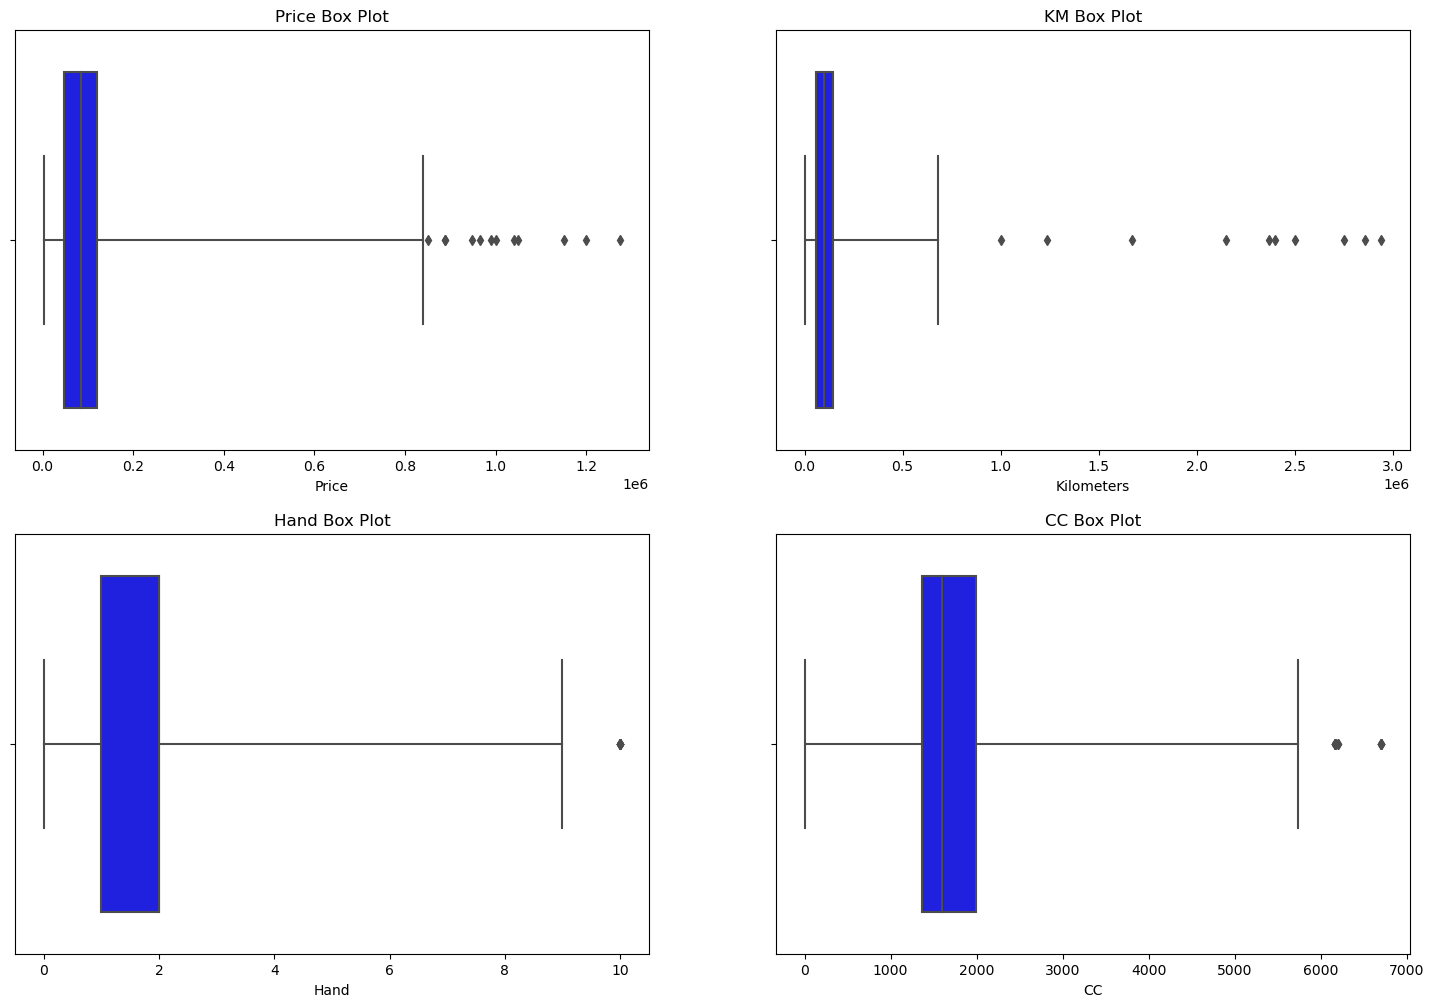

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
sns.boxplot(carsDF["Price"], whis=10, color="blue", ax=axes[0][0])
axes[0][0].set_title('Price Box Plot')
sns.boxplot(carsDF["Kilometers"], whis=7, color="blue", ax=axes[0][1])
axes[0][1].set_title('KM Box Plot')
sns.boxplot(carsDF["Hand"], whis=7, color="blue", ax=axes[1][0])
axes[1][0].set_title('Hand Box Plot')
sns.boxplot(carsDF["CC"], whis=6, color="blue", ax=axes[1][1])
axes[1][1].set_title('CC Box Plot')

In [40]:
carsDF = remove_outliers(carsDF)

In [41]:
carsDF.reset_index(drop=True, inplace=True)
carsDF

,Car_Type,Price,Year,Hand,CC,Kilometers,Color,Gear,Horse_Power
0,bmw x5,180000,2016,2,1995,110000,white,automaton,231
1,mazda 2,17000,2008,3,1498,137000,gray,automaton,103
2,mazda cx-3,130000,2023,1,1496,250,white,automaton,116
3,kia picanto,76000,2019,1,1248,45600,white,automaton,84
4,hyundai tucson,79000,2017,3,1999,103000,black,automaton,155
...,...,...,...,...,...,...,...,...,...
6127,skoda octavia,103000,2019,1,999,68000,black,automaton,115
6128,bmw 3 series,225000,2019,1,1998,74000,gray,automaton,252
6129,subaru forester,42500,2010,2,1994,300000,gray,automaton,150
6130,subaru forester,82000,2015,2,1995,114000,gray,automaton,150


## EDA

### EDA Types

- HeatMap for car features.
- Pairplot for car featureas.
- Pie plot for car colors.
- Bar plots for top 10 highest/lowest average car prices.
- Line plots for Hand Evolution Over Years and for Average Car Prices Over Years.
- Scatter plots for Mileage vs. Car Prices, Engine Displacement vs. Car Prices and Hand vs. Car Prices.
- Scatter plot for Hand Evolution Over Years with emphasis to gear type.
- Scatter plot for Price Evolution Over Years with emphasis to gear type.
- Scatter plot for Mileage Evolution Over Years with emphasis to gear type.
- Scatter plot for Engine Displacement Evolution Over Price with emphasis to car's color.
- Viloin plot for Car Prices across Transmission Types.
- Histogram of Car Types by Price.

### Conclusion:

#### In the last 5 years there is a noticeable decrease in the amount of manual vehicles:
- In the past five years, there has been a significant decline in manual vehicles, driven by consumer preference for automatic transmissions and the rise of electric cars. This shift reflects advancements in automatic transmission technology and the growing popularity of environmentally friendly electric vehicles. The noticeable decrease in the number of manual vehicles over the last five years can be attributed to multiple factors, including the increasing popularity of automatic transmissions driven by technological advancements.

- However, the rise of electric cars has also played a significant role in this trend. As more consumers embrace electric vehicles for their environmental benefits and technological innovation, the shift towards automatic transmissions becomes more pronounced, further contributing to the decline in manual vehicles.

#### Most vehicles are white, black and silver colors.

#### The price of most vehicles will range from 4,000₪ to 200,000₪.

#### The Evolution of Vehicle Value: From Depreciation to Collectibility:
- Vehicles typically experience a depreciation in value over many years before potentially gaining value as collectible vehicles. This depreciation occurs due to factors such as wear and tear, technological advances, and changes in consumer preferences.
- However, certain vehicles with unique features, limited production numbers, or historical significance may eventually become collectible and increase in value over time.

#### The Relationship Between Car Yearbook and Price:
- The effect of the car's yearbook on its price is a noticeable factor in the automotive market. The year of manufacture or model year plays a significant role in determining a car's price. Generally, newer vehicles tend to command higher prices compared to older ones.

- This is due to several reasons, including advancements in technology, improved safety features, and updated designs. Buyers often place a premium on newer models, as they offer the latest innovations and represent a higher perceived value. 

- Additionally, newer vehicles may come with warranties and extended service plans, further influencing their pricing. The yearbook effect highlights the importance of considering the car's age and model year when assessing its market value.

#### The effect of the engine volume on the price:
- The effect of engine volume on the price of a car is a significant factor in determining its market value. In general, cars with larger engine volumes tend to have higher prices compared to those with smaller engine volumes. This is because larger engines often offer greater power and performance, which can be appealing to buyers seeking a more dynamic driving experience.

- Additionally, cars with larger engines may be associated with higher-end models or luxury vehicles, further contributing to their higher price tags.

- However, it is essential to consider other factors such as fuel efficiency, brand reputation, and overall vehicle condition when evaluating the relationship between engine volume and price.

<AxesSubplot:>

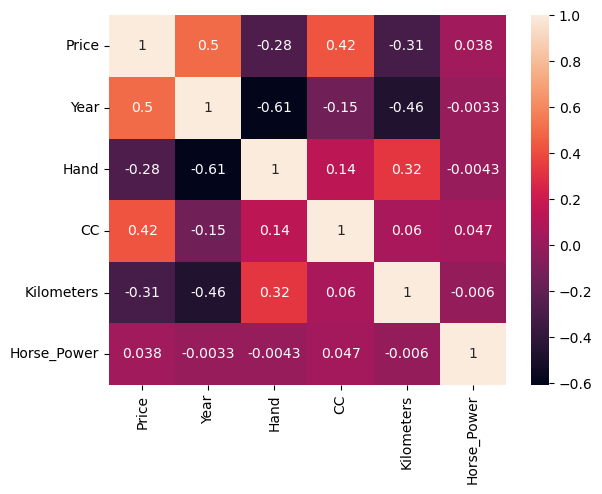

In [76]:
edaDF=pd.DataFrame(carsDF,columns = ['Price','Year','Hand','CC','Kilometers','Horse_Power'])
sns.heatmap(edaDF.corr(), annot=True)

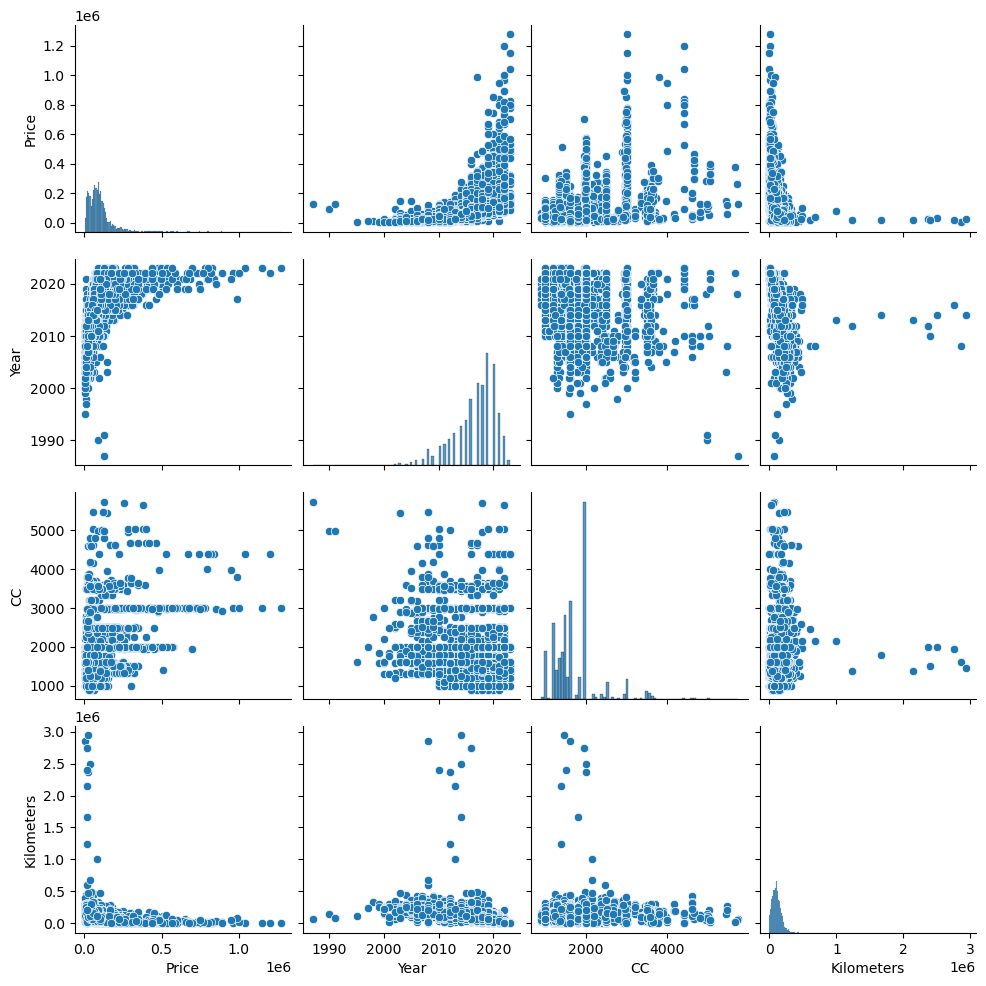

In [77]:
sns.pairplot(carsDF[['Price','Year','CC','Kilometers']])

<function matplotlib.pyplot.show(close=None, block=None)>

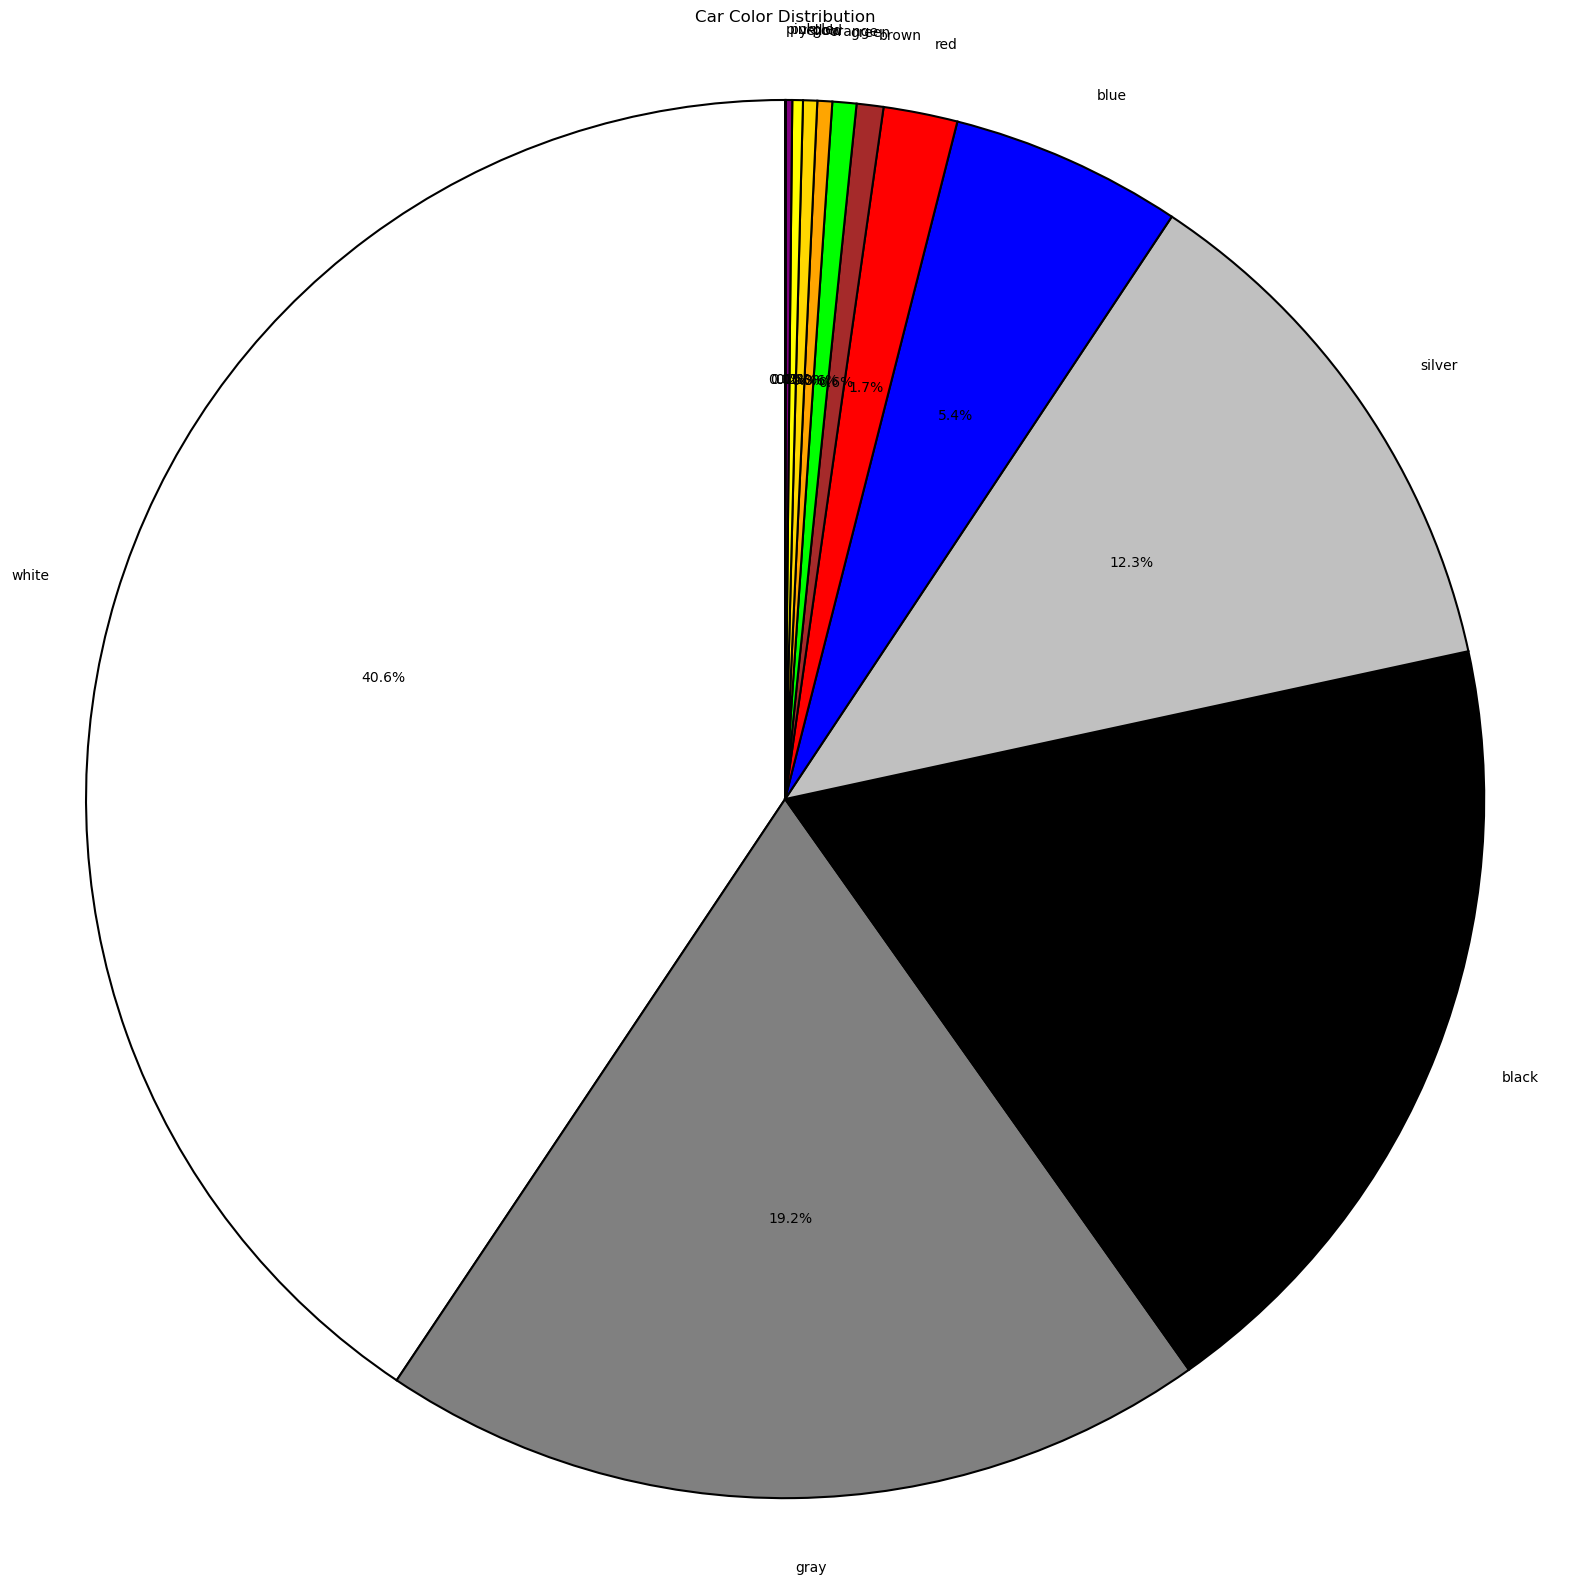

In [78]:
colors = carsDF["Color"]
color_counts = colors.value_counts()
labels = color_counts.index.tolist()
counts = color_counts.tolist()
color_palette = ["#FFFFFF", "#808080", "#000000", "#C0C0C0", "#0000FF","#FF0000", "#A52A2A", "#00FF00", "#FFA500", "#FFD700", "#FFFF00", "#800080", "#FFC0CB"]
plt.figure(figsize = (20,20))
plt.pie(counts, labels=labels, colors=color_palette, autopct="%1.1f%%", startangle=90, wedgeprops = {"edgecolor":"black", "linewidth":1.5})
plt.title("Car Color Distribution")
plt.axis("equal")
plt.show

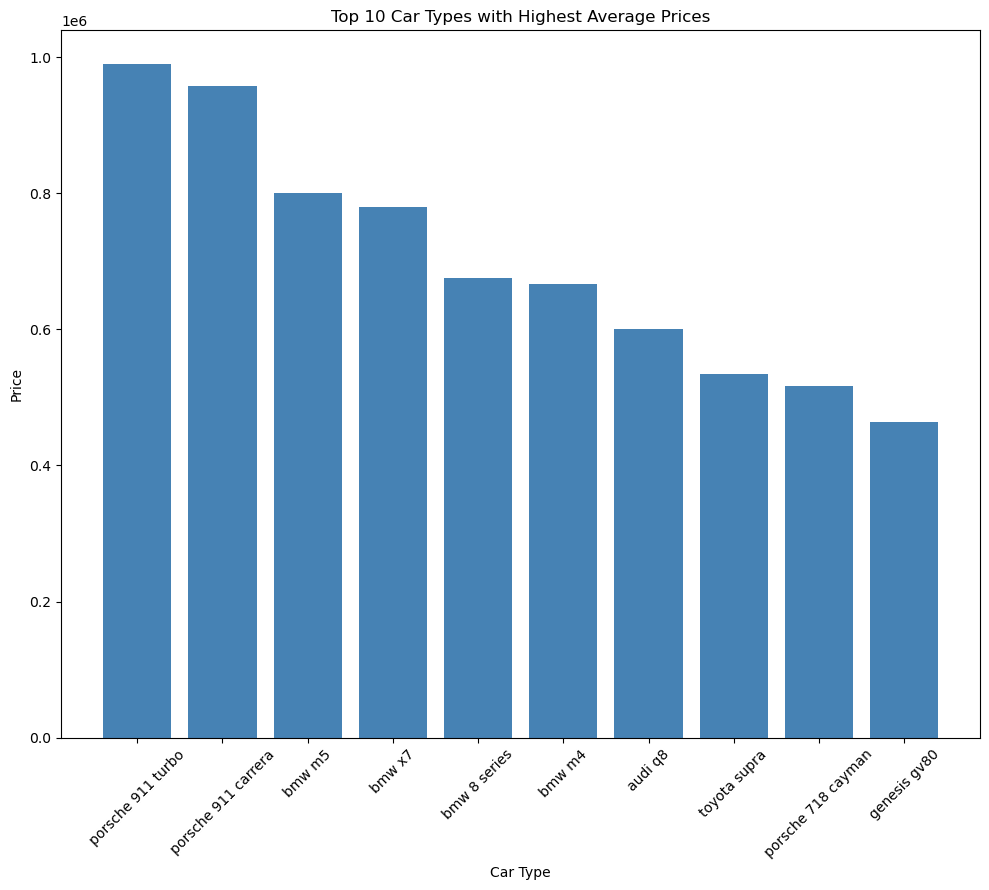

In [79]:
makes = carsDF["Car_Type"]
prices = carsDF["Price"]
avg_prices = carsDF.groupby("Car_Type")["Price"].mean()
sorted_avg_prices = avg_prices.sort_values(ascending=False)
top_makes = sorted_avg_prices.head(10)

plt.figure(figsize=(10, 9))
plt.bar(top_makes.index, top_makes.values, color="steelblue")
plt.xlabel("Car Type")
plt.ylabel("Price")
plt.title("Top 10 Car Types with Highest Average Prices")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

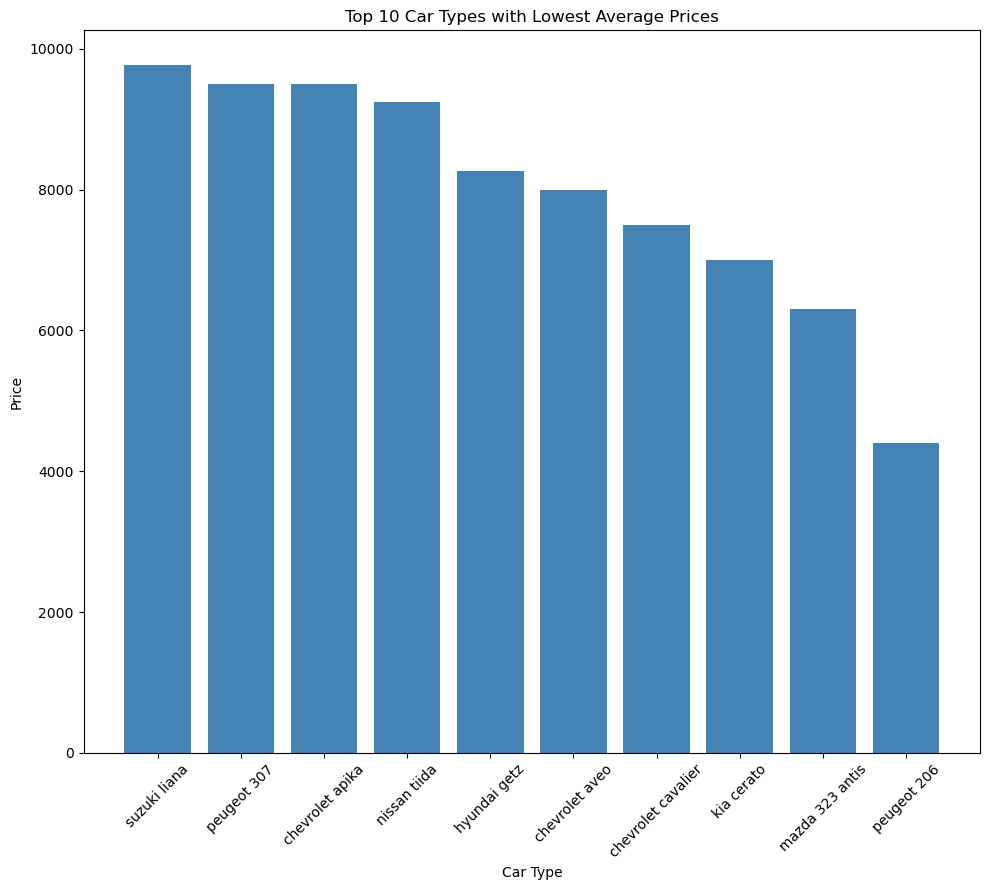

In [80]:
makes = carsDF["Car_Type"]
prices = carsDF["Price"]
avg_prices = carsDF.groupby("Car_Type")["Price"].mean()
sorted_avg_prices = avg_prices.sort_values(ascending=False)
top_makes = sorted_avg_prices.tail(10)

plt.figure(figsize=(10, 9))
plt.bar(top_makes.index, top_makes.values, color="steelblue")
plt.xlabel("Car Type")
plt.ylabel("Price")
plt.title("Top 10 Car Types with Lowest Average Prices")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

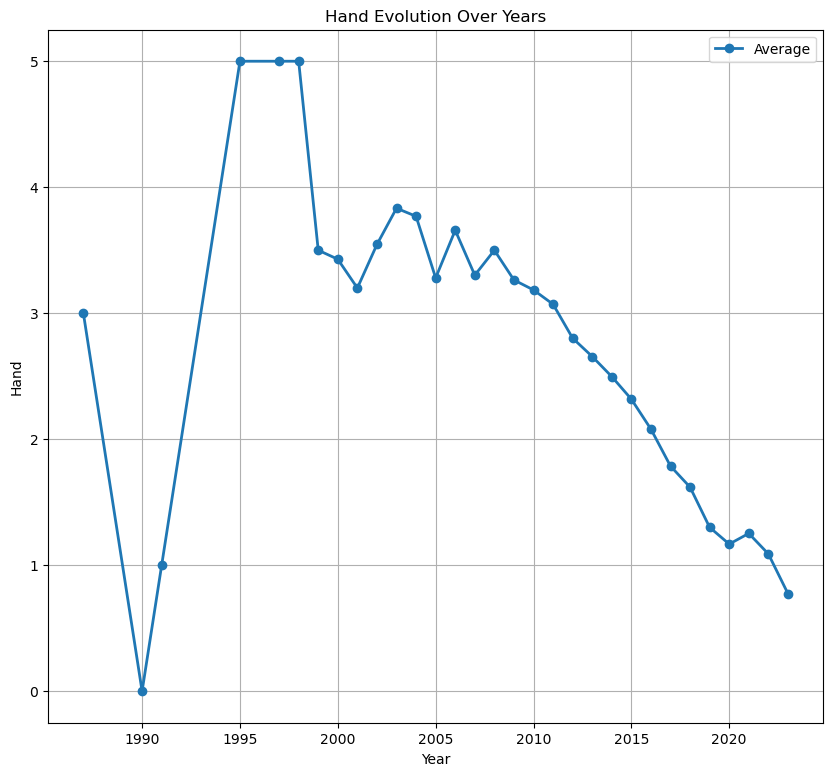

In [81]:
avg_hand_by_year = carsDF.groupby("Year")["Hand"].mean()
plt.figure(figsize=(10,9))
# plt.scatter(carsDF["Year"], carsDF["Hand"], s=50, alpha=0.5)
plt.plot(avg_hand_by_year.index, avg_hand_by_year.values, marker = 'o', linestyle='-', linewidth = 2, label="Average")
plt.xlabel("Year")
plt.ylabel("Hand")
plt.title("Hand Evolution Over Years")
# plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show

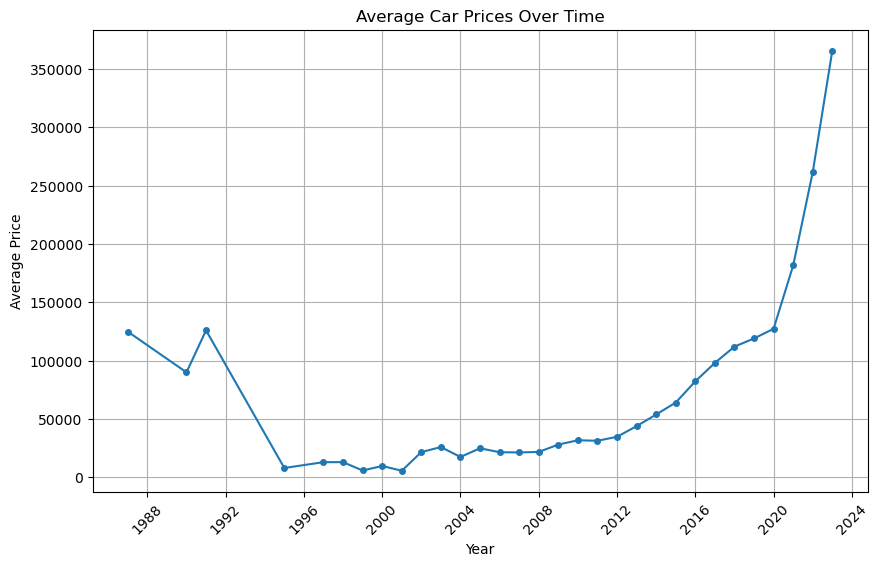

In [82]:
price_series = carsDF['Price'].copy()
year_series = carsDF['Year'].copy()

# Convert 'year' column to datetime type
year_series = pd.to_datetime(year_series, format='%Y')

# Group by year and calculate the average price
aggregated_data = carsDF.groupby(year_series)['Price'].mean()

# Plot the car prices over time
plt.figure(figsize=(10, 6))
plt.plot(aggregated_data.index, aggregated_data.values, marker='o', linestyle='-', markersize=4)
plt.title('Average Car Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

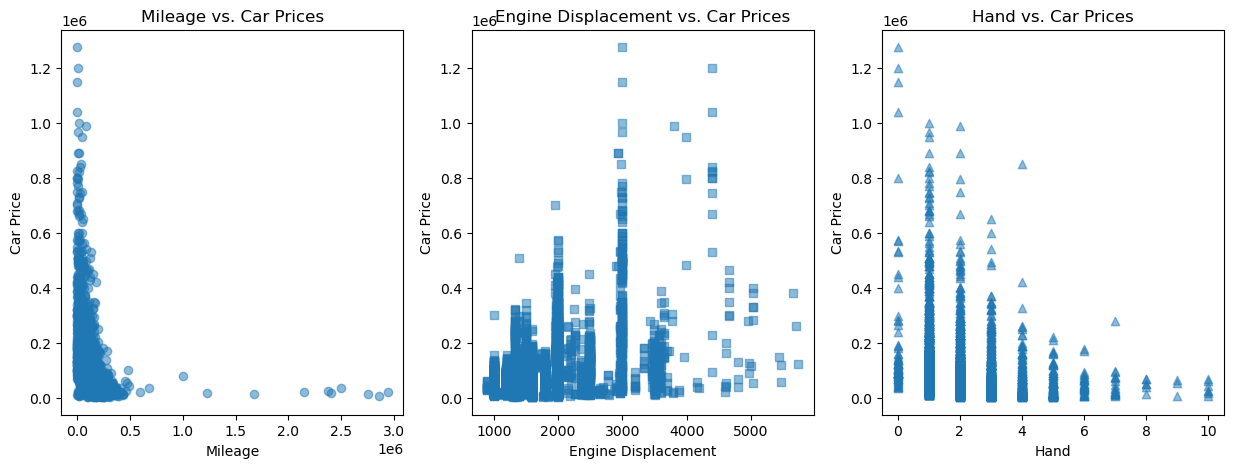

In [83]:
mileage = carsDF['Kilometers']
engine_displacement = carsDF['CC']
hand = carsDF['Hand']
car_prices = carsDF['Price']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Scatter plot 1: Mileage vs. Car Prices
axs[0].scatter(mileage, car_prices, marker='o', alpha=0.5)
axs[0].set_title('Mileage vs. Car Prices')
axs[0].set_xlabel('Mileage')
axs[0].set_ylabel('Car Price')

# Scatter plot 2: Engine Displacement vs. Car Prices
axs[1].scatter(engine_displacement, car_prices, marker='s', alpha=0.5)
axs[1].set_title('Engine Displacement vs. Car Prices')
axs[1].set_xlabel('Engine Displacement')
axs[1].set_ylabel('Car Price')

# Scatter plot 3: Horsepower vs. Car Prices
axs[2].scatter(hand, car_prices, marker='^', alpha=0.5)
axs[2].set_title('Hand vs. Car Prices')
axs[2].set_xlabel('Hand')
axs[2].set_ylabel('Car Price')


plt.show()

<AxesSubplot:xlabel='Hand', ylabel='Year'>

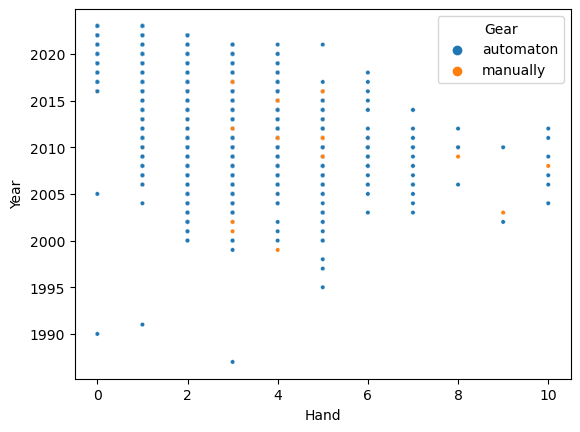

In [84]:
sns.scatterplot(x = 'Hand', y = 'Year', s = 10, hue = 'Gear', data = carsDF)

<AxesSubplot:xlabel='Price', ylabel='Year'>

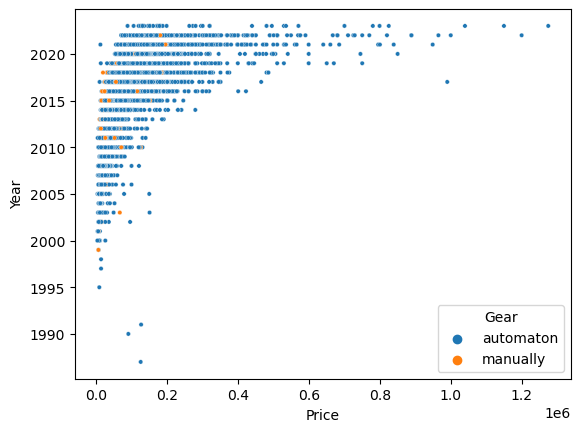

In [85]:
sns.scatterplot(x = 'Price', y = 'Year', s = 10, hue = 'Gear', data = carsDF)

<AxesSubplot:xlabel='Kilometers', ylabel='Year'>

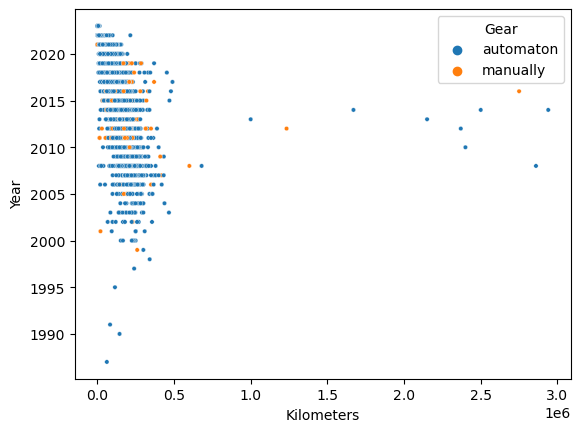

In [86]:
sns.scatterplot(x = 'Kilometers', y = 'Year', s = 10, hue = 'Gear', data = carsDF)

<AxesSubplot:xlabel='Price', ylabel='CC'>

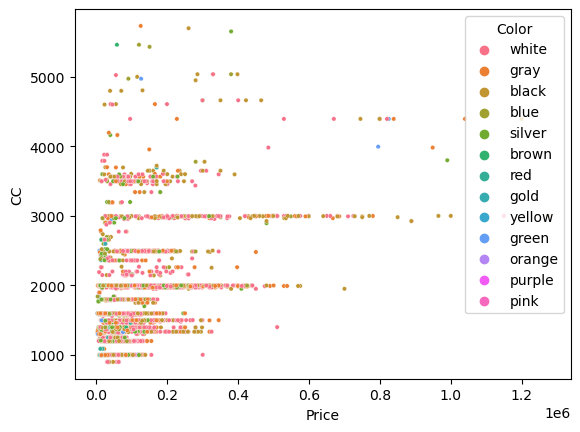

In [87]:
sns.scatterplot(x = 'Price', y = 'CC', s = 10, hue = 'Color', data = carsDF)

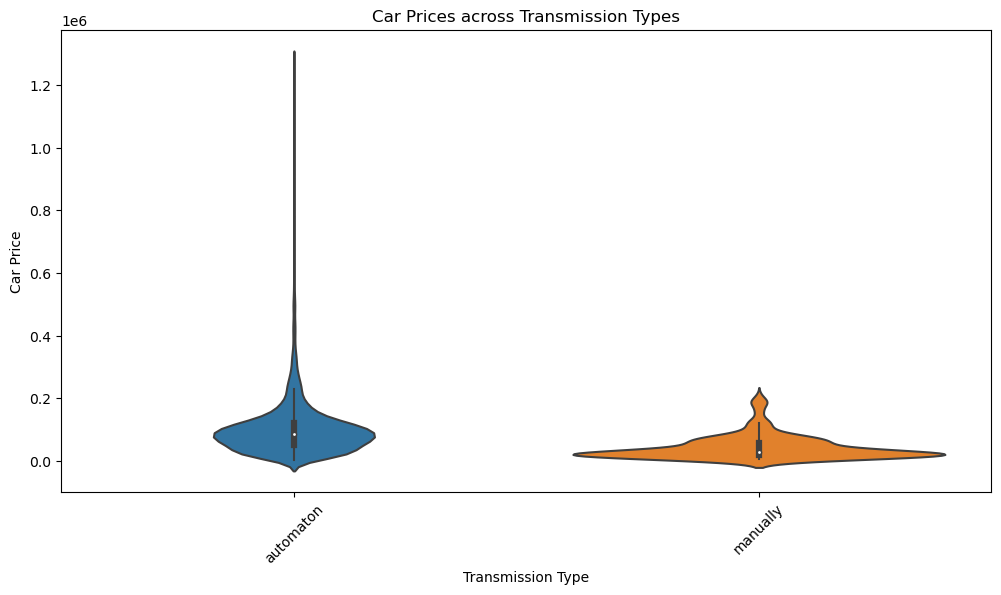

In [88]:
transmission_type = carsDF['Gear'].copy()
car_prices = carsDF['Price'].copy()

# Create a DataFrame for the violin plot
df_violin = pd.DataFrame({'Transmission Type': transmission_type,'Car Price': car_prices})

# Plot the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_violin, x='Transmission Type', y='Car Price')
plt.title('Car Prices across Transmission Types')
plt.xlabel('Transmission Type')
plt.ylabel('Car Price')
plt.xticks(rotation=45)
plt.show()

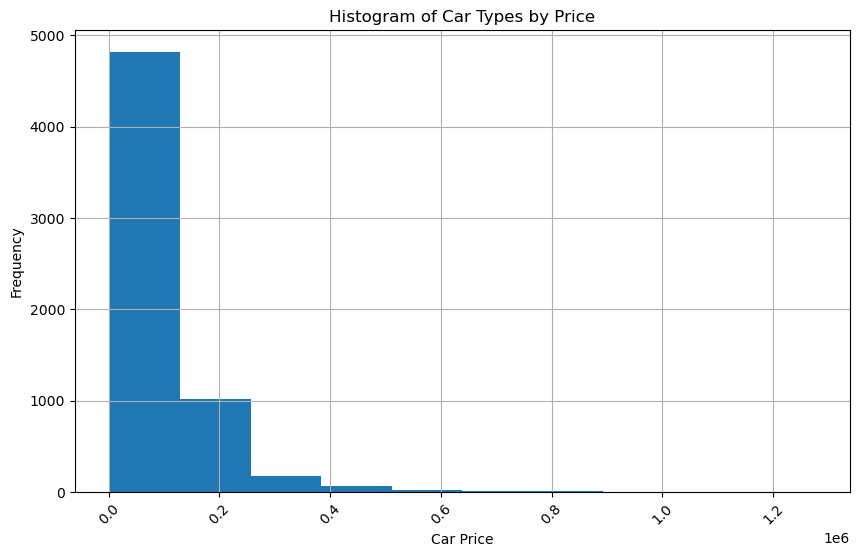

In [89]:
car_types = carsDF['Car_Type'].copy()
car_prices = carsDF['Price'].copy()

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(car_prices, bins=10)
plt.title('Histogram of Car Types by Price')
plt.xlabel('Car Price')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Machine Learning

#### We converted the entire database to a numerical representation.

#### Finding the best machine learning method:
- In our pursuit of finding the most accurate method, we employed three algorithms for our machine learning task: K-Nearest Neighbors (KNN), Linear Regression, and Random Forest.

- Each algorithm brings its unique approach to the problem at hand. KNN is a non-parametric method that predicts the value of a data point based on the values of its nearest neighbors. Linear Regression, on the other hand, aims to establish a linear relationship between the dependent and independent variables. Random Forest combines the predictions of multiple decision trees to arrive at a more robust and accurate prediction.

- By utilizing these three algorithms, we sought to explore different modeling techniques and select the one that best suits our data and yields the most precise results.

#### Random Forest method is the most efficient:
- Upon comparing the R^2 and MSE results obtained from different methods, it becomes evident that the Random Forest algorithm outperformed the others, showcasing the best performance.

- The R^2 value of 0.87 indicates that the Random Forest model explains a significant portion of the variance in the data, providing a good fit to the observed car prices.

- Additionally, the MSE value of 1153777595.02 suggests that the model's predictions are relatively close to the actual prices, with lower prediction errors compared to the other methods.

- These findings indicate that the Random Forest algorithm is the most suitable approach for accurately predicting car prices based on the given dataset.

#### The 5 features that had the most impact from Random Forest:
- After analyzing the Random Forest model's feature importances, we discovered that several factors significantly influence the prediction of car prices. 

- The top five features include kilometers, year, cc (engine displacement), hand (condition), and horsepower. Kilometers, indicating the mileage of a car, emerges as the most influential feature, suggesting that the lower the mileage, the higher the predicted price. The year of the car follows closely, indicating that newer vehicles tend to command higher prices. Engine displacement (cc) also plays a significant role, with larger engine sizes positively impacting the predicted price. The condition of the car, represented by the "hand" feature, and the horsepower of the engine also contribute to determining the price. 

- These findings highlight the importance of considering mileage, age, engine characteristics, condition, and power when estimating car prices using the Random Forest model.

In [42]:
# Preparation for machine learning
carsDF = convert_categorial_data(carsDF)
carsDF

,Price,Year,Hand,CC,Kilometers,Gear,Horse_Power,Car_Type_595 eberth,Car_Type_audi a1,Car_Type_audi a3,...,Color_gold,Color_gray,Color_green,Color_orange,Color_pink,Color_purple,Color_red,Color_silver,Color_white,Color_yellow
0,180000,2016,2,1995,110000,1,231,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,17000,2008,3,1498,137000,1,103,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,130000,2023,1,1496,250,1,116,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,76000,2019,1,1248,45600,1,84,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,79000,2017,3,1999,103000,1,155,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6127,103000,2019,1,999,68000,1,115,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6128,225000,2019,1,1998,74000,1,252,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6129,42500,2010,2,1994,300000,1,150,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6130,82000,2015,2,1995,114000,1,150,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [43]:
X = carsDF.drop("Price", axis=1)
y = carsDF["Price"]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [46]:
linear_y_pred = linear_model.predict(X_test)

In [47]:
linear_mse = mean_squared_error(y_test, linear_y_pred)
linear_r2 = r2_score(y_test, linear_y_pred)
print("Mean Squared Error:", linear_mse)
print("R^2 Score:", linear_r2)

Mean Squared Error: 1941956369.81459
R^2 Score: 0.7856608814331406


In [48]:
successDF = pd.DataFrame({"real_data":y_test, "predicted_data":linear_y_pred})
successDF.reset_index(drop=True, inplace=True)
successDF.head(15)

,real_data,predicted_data
0,94000,81639.573075
1,61000,70267.276500
2,28000,109365.849029
3,139000,150826.909877
4,149900,177835.315573
5,83000,77546.322015
6,43985,84482.702875
7,87787,124684.708996
8,17500,21480.878187
9,85500,100059.292683


In [49]:
successDF.to_csv("predicteddatalinear.csv", index=False)

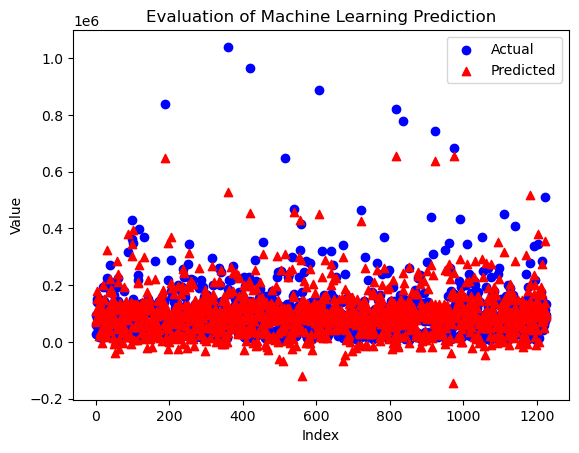

In [50]:
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')

plt.scatter(range(len(linear_y_pred)), linear_y_pred, color='red', marker='^', label='Predicted')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Evaluation of Machine Learning Prediction')

plt.legend()

plt.show()

In [51]:
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [52]:
RF_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [53]:
RF_y_pred = RF_model.predict(X_test)

In [54]:
RF_accuracy = accuracy_score(y_test, RF_y_pred)
RF_mse = mean_squared_error(y_test, RF_y_pred)
RF_r2 = r2_score(y_test, RF_y_pred)

In [55]:
print("Mean Squared Error:", RF_mse)
print("Accuracy Score:", RF_accuracy)
print("R^2 Score:", RF_r2)

Mean Squared Error: 1153777595.0179298
Accuracy Score: 0.026079869600651995
R^2 Score: 0.8726543620740845


In [56]:
successDF = pd.DataFrame({"real_data":y_test, "predicted_data":RF_y_pred})
successDF.reset_index(drop=True, inplace=True)
successDF.head(15)

,real_data,predicted_data
0,94000,106260
1,61000,59900
2,28000,69000
3,139000,134900
4,149900,160000
5,83000,75000
6,43985,32000
7,87787,78985
8,17500,19500
9,85500,105000


In [57]:
successDF.to_csv("predicteddataRandomForest.csv", index=False)

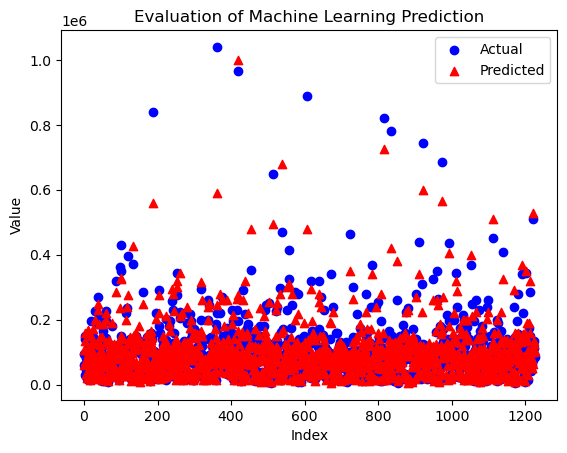

In [58]:
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')

plt.scatter(range(len(RF_y_pred)), RF_y_pred, color='red', marker='^', label='Predicted')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Evaluation of Machine Learning Prediction')

plt.legend()

plt.show()

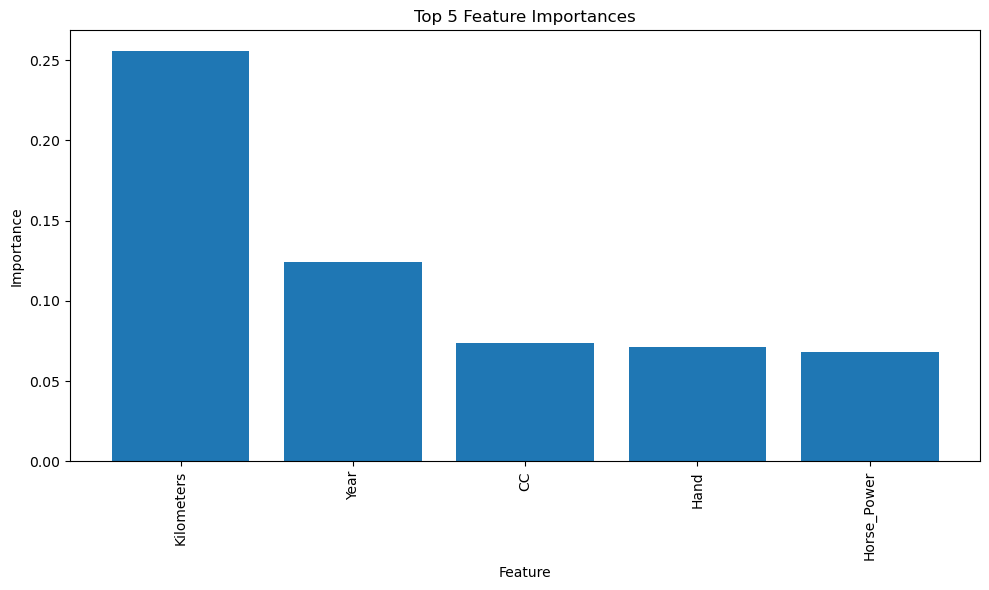

In [62]:
importances = RF_model.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]

# Get the top 5 feature names and importances
top_feature_names = X_train.columns[sorted_indices][:5]
top_importances = sorted_importances[:5]

# Plot top 5 feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_importances)), top_importances, tick_label=top_feature_names)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 5 Feature Importances')
plt.tight_layout()
plt.show()

In [107]:
k_values = range(1, 16)
mean_scores = []
for k in k_values:
    KNNmodel = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(KNNmodel, X_train, y_train, cv=5)
    mean_scores.append(np.mean(scores))
best_k = k_values[np.argmax(mean_scores)]

C:\Users\Mor\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Mor\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Mor\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior 

In [108]:
best_k

1

In [65]:
KNNmodel = KNeighborsClassifier(n_neighbors=1)

In [66]:
KNNmodel.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [67]:
KNN_y_pred = KNNmodel.predict(X_test)

C:\Users\Mor\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [68]:
KNN_accuracy = accuracy_score(y_test, KNN_y_pred)
KNN_mse = mean_squared_error(y_test, KNN_y_pred)
KNN_r2 = r2_score(y_test, KNN_y_pred)

In [69]:
print("Mean Squared Error:", KNN_mse)
print("Accuracy Score:", KNN_accuracy)
print("R^2 Score:", KNN_r2)

Mean Squared Error: 4554325134.252648
Accuracy Score: 0.0032599837000814994
R^2 Score: 0.4973264847161283


In [70]:
successDF = pd.DataFrame({"real_data":y_test, "predicted_data":KNN_y_pred})
successDF.reset_index(drop=True, inplace=True)
successDF.head(15)

,real_data,predicted_data
0,94000,23000
1,61000,80000
2,28000,180000
3,139000,134900
4,149900,129000
5,83000,79330
6,43985,73735
7,87787,325000
8,17500,23900
9,85500,109000


In [71]:
successDF.to_csv("predicteddataKNN.csv", index=False)

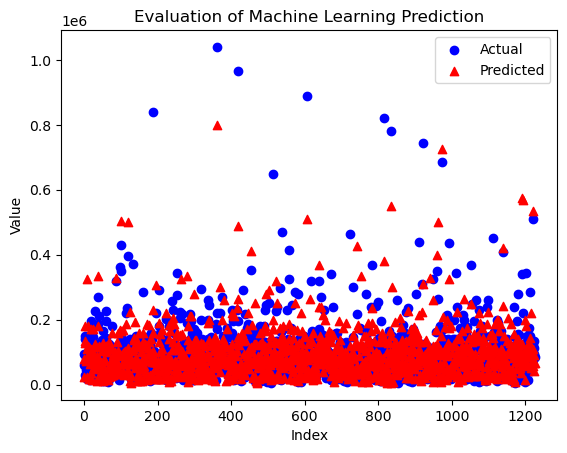

In [72]:
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')

plt.scatter(range(len(KNN_y_pred)), KNN_y_pred, color='red', marker='^', label='Predicted')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Evaluation of Machine Learning Prediction')

plt.legend()

plt.show()

In [117]:
MLCompareDF = pd.DataFrame({"ML Algorithm":["Linear Regression", "Random Forest", "KNN"], "R^2 Evaluation":[linear_r2, RF_r2, KNN_r2], "MSE":["{:.2f}".format(linear_mse), "{:.2f}".format(RF_mse), "{:.2f}".format(KNN_mse)]})
MLCompareDF

,ML Algorithm,R^2 Evaluation,MSE
0,Linear Regression,0.785661,1941956369.81
1,Random Forest,0.872654,1153777595.02
2,KNN,0.497326,4554325134.25


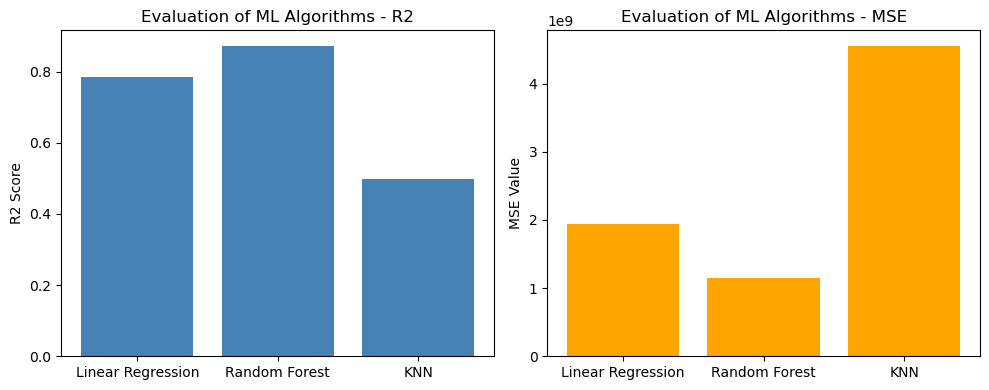

In [118]:
algorithm_names = ["Linear Regression", "Random Forest", "KNN"]
r2_scores = [linear_r2, RF_r2, KNN_r2]
mse_values = [linear_mse, RF_mse, KNN_mse]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Bar plot for R2 scores
ax1.bar(algorithm_names, r2_scores, color='steelblue')
ax1.set_ylabel('R2 Score')
ax1.set_title('Evaluation of ML Algorithms - R2')

# Bar plot for MSE values
ax2.bar(algorithm_names, mse_values, color='orange')
ax2.set_ylabel('MSE Value')
ax2.set_title('Evaluation of ML Algorithms - MSE')

plt.tight_layout()
plt.show()